In [1]:
import torch
import firedrake as fd
import numpy as np
import matplotlib.pyplot as plt

from burgers import BurgersDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


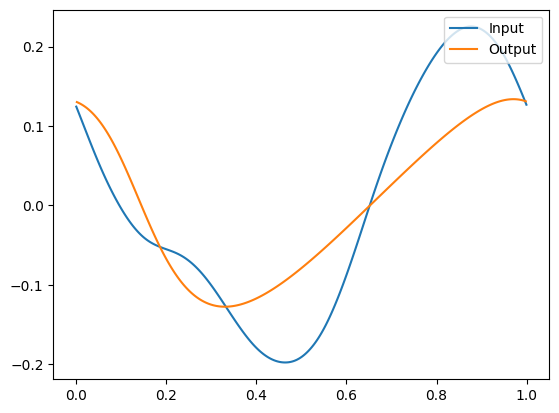

In [6]:
nx = 8192
batch_num = 27
filename = f"data/samples/N{nx}_nu0.01_samples40_batch{batch_num}"

with fd.CheckpointFile(f"data/meshes/N{nx}.h5", "r") as file:
    function_space = fd.FunctionSpace(file.load_mesh(), "CG", degree=1)


data = torch.load(f"{filename}.pt").unsqueeze(2).to(device=device, dtype=torch.float32)

index = 35
datapoint = data[index]
func_in = fd.Function(function_space, val=datapoint[0][0].detach().cpu())
func_out = fd.Function(function_space, val=datapoint[1][0].detach().cpu())

fig, axes = plt.subplots()

fd.plot(func_in, axes=axes, label="Input")
fd.plot(func_out, axes=axes, label="Output")
axes.legend()


In [3]:

nx = 8192
batch_num = 1
filename = f"data/samples/N{nx}_nu0.01_samples200_batch{batch_num}"

max_modes = 8
d = 10

# net = torch.load(f"models_L2/nx_{nx}__d_{d}__max_modes_{max_modes}.pt").to(device=device)
# param_num = sum(p.numel() for p in net.parameters() if p.requires_grad)
# print(f"Number of parameters: {param_num}")

data = torch.load(f"{filename}.pt").unsqueeze(2).to(device=device, dtype=torch.float32)
# grid = torch.linspace(0, 1, nx, device=device)
# testset = BurgersDataset(data[int(0.8 * len(data)):], grid)

# prediction_coeffs = net(testset[:][0]).detach().cpu()

with fd.CheckpointFile(f"data/meshes/N{nx}.h5", "r") as file:
    function_space = fd.FunctionSpace(file.load_mesh(), "CG", degree=1)




initial_functions = []
solutions = []
predictions = []
for predict, datapoint in zip(prediction_coeffs, testset):
    initial_functions.append(fd.Function(function_space, val=datapoint[0][0].detach().cpu()))
    solutions.append(fd.Function(function_space, val=datapoint[1][0].detach().cpu()))
    predictions.append(fd.Function(function_space, val=predict[0]))

# Number of points for plotting
num_plot_points = 1000
plot_points = np.linspace(0, 1, num_plot_points)

# Create a figure for plotting
fig, ax = plt.subplots()

# Plot each function
index = 25
for func, label in zip([solutions[index], predictions[index], initial_functions[index]], ["Firedrake solution", "Network solution", "Initial condition"]):
    # Evaluate the function at the plot points
    plot_values = np.array([func.at(x) for x in plot_points])

    # Plot the function
    ax.plot(plot_points, plot_values, label=label)

# Set plot labels and title
ax.set_xlabel("$x$")
ax.set_title(f"Burgers solutions - Firedrake and Network, $N_x={nx}, \, D={d}$")
ax.legend()

# Show the plot
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'data/samples/N8192_nu0.01_samples200_batch1.pt'

In [1]:
from firedrake import *

firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


In [2]:
mesh = PeriodicIntervalMesh(100, 1)


In [17]:
her_fs = FunctionSpace(mesh, "HER", 3)
x = SpatialCoordinate(mesh)[0]
v = TestFunction(her_fs)
f = assemble(sin(2 * pi * x) * v * dx)
sum(f.dat.data)

np.float64(-1.9714183627575488e-16)

In [20]:
her_fs = FunctionSpace(mesh, "CG", 3)
x = SpatialCoordinate(mesh)[0]
v = TestFunction(her_fs)
f = assemble(sin(2 * pi * x) * v * dx)
sum(f.dat.data)

np.float64(4.517057301117733e-17)

In [25]:
mesh.__dict__

{'uid': 3,
 '_ufl_id': 3,
 '_ufl_cargo': <firedrake.mesh.MeshGeometryCargo at 0x7f7dcf043700>,
 '_ufl_coordinate_element': VectorElement(FiniteElement('Discontinuous Lagrange', interval, 1, variant='equispaced'), dim=1, variant='equispaced'),
 '_topological_dimension': 1,
 '_geometric_dimension': 1,
 'name': 'firedrake_default',
 '_tolerance': 0.5,
 'num_vertices': <bound method MeshTopology.num_vertices of <firedrake.mesh.MeshTopology object at 0x7f7e7d767940>>,
 'block_variable': <pyadjoint.block_variable.BlockVariable at 0x7f7e7d945e70>,
 'extruded': False,
 'variable_layers': False,
 '_ad_coordinate_space': None,
 'comm': <mpi4py.MPI.Intracomm at 0x7f7e7d98d310>,
 'cell_set': Set((np.int64(100), np.int64(100), np.int64(100)), 'Cells'),
 'extruded_periodic': False,
 'measure_set': <bound method AbstractMeshTopology.measure_set of <firedrake.mesh.MeshTopology object at 0x7f7e7d767940>>,
 '_comm': <mpi4py.MPI.Intracomm at 0x7f7dcf03ecf0>,
 'cell_sizes': Coefficient(WithGeometry(Functi

In [2]:
def check_downsample(fs1, data1, fs2, data2, index=100):
    fig1, axes1 = plt.subplots()
    fig2, axes2 = plt.subplots()

    fd.plot(fd.Function(fs1, val=data1[index, 0, :], name="FS1 - a"), axes=axes1)
    fd.plot(fd.Function(fs2, val=data2[index, 0, :], name="FS2 - a"), axes=axes1)
    fd.plot(fd.Function(fs1, val=data1[index, 1, :], name="FS1 - u"), axes=axes2)
    fd.plot(fd.Function(fs2, val=data2[index, 1, :], name="FS2 - u"), axes=axes2)

    axes1.legend()
    axes1.grid()
    axes2.legend()
    axes2.grid()

    plt.show()

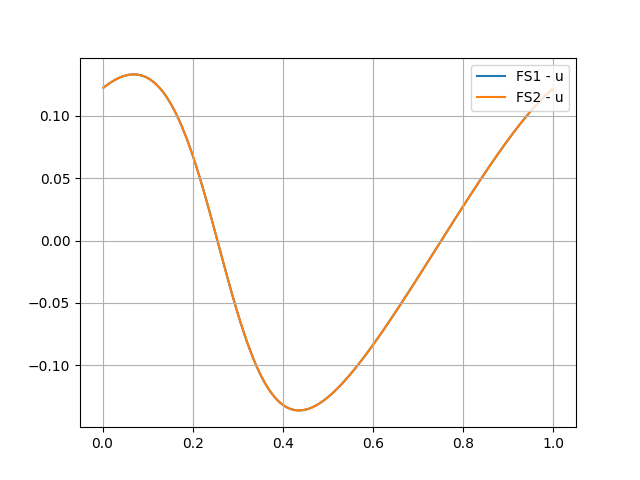

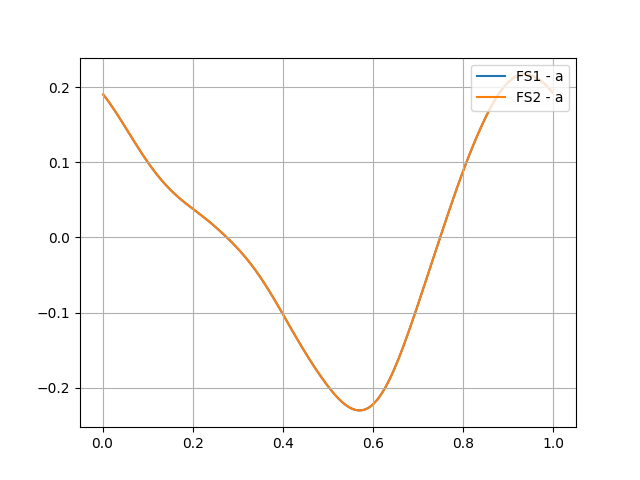

In [4]:
%matplotlib widget
N1 = 8192
N2 = 512

data1 = torch.load(f"data/burgers/samples/N{N1}_nu001_T1_samples1200.pt").numpy()
data2 = torch.load(f"data/burgers/samples/N{N2}_nu001_T1_samples1200.pt").numpy()

with fd.CheckpointFile(f"data/burgers/meshes/N{N1}.h5", "r") as file:
    fs1 = fd.FunctionSpace(file.load_mesh(), "CG", 1)

with fd.CheckpointFile(f"data/burgers/meshes/N{N2}.h5", "r") as file:
    fs2 = fd.FunctionSpace(file.load_mesh(), "CG", 1)

check_downsample(fs1, data1, fs2, data2)
